In [1]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer






# Keras
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
#from keras.backend.tensorflow_backend import set_session
#physical_devices = tf.config.list_physical_devices()
#print(physical_devices)
#physical_devices = tf.config.list_physical_devices('XLA_GPU')
#print(physical_devices)
#tf.config.experimental.set_memory_growth(physical_devices[0], True)


# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools


os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0"; 
# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\GamingYM\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 64

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [4]:
# IMPORT DATA
dataset_filename = "data.csv"
fileexist =os.path.exists("./content/input/datacut.csv")
print("file exists: ",fileexist )
dataset_path = os.path.join(".","content\input",dataset_filename)
#dataset_path = os.path.join(".." .é/content/input/datacut.csv")
print("Open file:", dataset_path)
df = pd.read_csv(dataset_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)


file exists:  True
Open file: .\content\input\data.csv


In [5]:
#DISPLAY SIZE
print("Dataset size:", len(df))

Dataset size: 1600000


In [6]:
# SHOW FIRST 5 ENTRIES
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [7]:
#Map target label to String¶
#0 -> NEGATIVE
#2 -> NEUTRAL
#4 -> POSITIVE
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    
    return decode_map[int(label)]

In [8]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(int(x)))

Wall time: 581 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

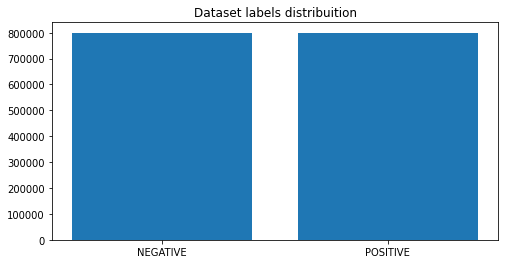

In [9]:
# SHOW LABEL DISTRIBUTION IN DATASET
target_cnt = Counter(df.target)

plt.figure(figsize=(8,4))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [10]:
#LOAD LEXICAL TOOLS 
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [11]:
#TEXT CLEANING AND STEMMING 
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [12]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

Wall time: 33 s


In [13]:
# DATA SPLIT 
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


In [14]:
%%time
documents = [_text.split() for _text in df_train.text] 

Wall time: 2 s


In [15]:
# DEFINITION OF WORD2VEC MODEL
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [16]:
w2v_model.build_vocab(documents)

2020-11-26 12:08:58,304 : INFO : collecting all words and their counts
2020-11-26 12:08:58,305 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-11-26 12:08:58,320 : INFO : PROGRESS: at sentence #10000, processed 72565 words, keeping 14005 word types
2020-11-26 12:08:58,335 : INFO : PROGRESS: at sentence #20000, processed 144393 words, keeping 21587 word types
2020-11-26 12:08:58,348 : INFO : PROGRESS: at sentence #30000, processed 215826 words, keeping 27541 word types
2020-11-26 12:08:58,362 : INFO : PROGRESS: at sentence #40000, processed 288271 words, keeping 32764 word types
2020-11-26 12:08:58,375 : INFO : PROGRESS: at sentence #50000, processed 359772 words, keeping 37587 word types
2020-11-26 12:08:58,395 : INFO : PROGRESS: at sentence #60000, processed 431431 words, keeping 42198 word types
2020-11-26 12:08:58,409 : INFO : PROGRESS: at sentence #70000, processed 503103 words, keeping 46458 word types
2020-11-26 12:08:58,426 : INFO : PROGRESS: at s

In [17]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30369


In [18]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

 examples, 1408443 words/s, in_qsize 15, out_qsize 0
2020-11-26 12:10:56,512 : INFO : EPOCH 19 - PROGRESS: at 85.55% examples, 1401448 words/s, in_qsize 15, out_qsize 0
2020-11-26 12:10:57,330 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-11-26 12:10:57,337 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-11-26 12:10:57,342 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-11-26 12:10:57,344 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-11-26 12:10:57,345 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-26 12:10:57,345 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-26 12:10:57,353 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-26 12:10:57,357 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-26 12:10:57,358 : INFO : EPOCH - 19 : training on 9227204 raw words (8222720 effective words) t

(263130271, 295270528)

In [19]:
#TESTING WORD2VEC MODEL
w2v_model.most_similar("love")

2020-11-26 12:12:13,935 : INFO : precomputing L2-norms of word weight vectors


[('luv', 0.567313551902771),
 ('loves', 0.5660104751586914),
 ('loved', 0.5358436703681946),
 ('adore', 0.5263367891311646),
 ('looove', 0.5084571838378906),
 ('amazing', 0.5073959231376648),
 ('awesome', 0.4682096242904663),
 ('loveee', 0.45910167694091797),
 ('loooove', 0.44825392961502075),
 ('loove', 0.4369145333766937)]

In [20]:

%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
Wall time: 11.9 s


In [21]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

Wall time: 17.3 s


In [22]:
#ADDING NEUTRAL TO THE LABELS
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [23]:
#ENCODING
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [24]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [25]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]], dtype=int64)

In [26]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [27]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [28]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          87125700  
_________________________________________________________________
dropout (Dropout)            (None, 300, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________


In [29]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [30]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [31]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=4096,
                    epochs=2,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/2


ResourceExhaustedError:  OOM when allocating tensor with shape[8192,300] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node sequential/lstm/while/body/_1/sequential/lstm/while/lstm_cell/dropout/random_uniform/RandomUniform}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_4130]

Function call stack:
train_function


In [32]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

626/626 [==============================] - 44s 71ms/step - loss: 0.4799 - accuracy: 0.7715

ACCURACY: 0.7714807391166687
LOSS: 0.4798840582370758
Wall time: 44.7 s


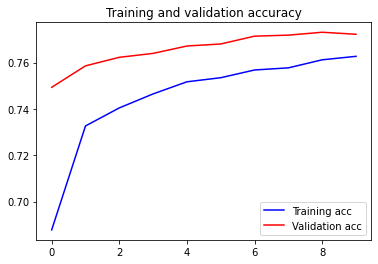

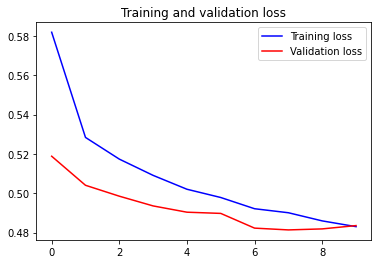

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [34]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [35]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [36]:
predict("I love the music")

{'label': 'POSITIVE',
 'score': 0.984112024307251,
 'elapsed_time': 0.4548616409301758}

In [37]:
predict("I hate the rain")

{'label': 'NEGATIVE',
 'score': 0.010806560516357422,
 'elapsed_time': 0.04999947547912598}

In [38]:
predict("i don't know what i'm doing")

{'label': 'NEUTRAL',
 'score': 0.46642976999282837,
 'elapsed_time': 0.0429995059967041}

In [39]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

6/6 [==============================] - 22s 4s/step
Wall time: 27.3 s


In [40]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

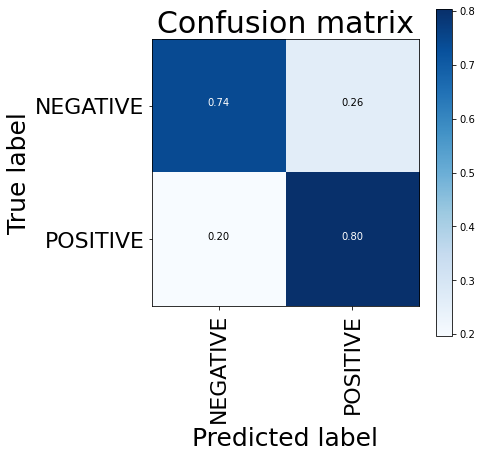

Wall time: 350 ms


In [41]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

In [42]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.79      0.74      0.76     19953
    POSITIVE       0.76      0.80      0.78     20048

    accuracy                           0.77     40001
   macro avg       0.77      0.77      0.77     40001
weighted avg       0.77      0.77      0.77     40001



In [43]:
accuracy_score(y_test_1d, y_pred_1d)

0.7714807129821755

In [44]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

2020-11-26 11:36:18,228 : INFO : saving Word2Vec object under model.w2v, separately None
2020-11-26 11:36:18,234 : INFO : not storing attribute vectors_norm
2020-11-26 11:36:18,236 : INFO : not storing attribute cum_table
2020-11-26 11:36:18,581 : INFO : saved model.w2v
